In [278]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from pygeocoder import Geocoder
import json
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
import difflib
import pprint

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


## Predict Is_Closed Yelp

In [122]:
yelpDF.columns.tolist()

['business_id',
 'business_name',
 'is_closed',
 'rating',
 'review_count',
 '$',
 '$$',
 '$$$']

In [123]:
X = yelpDF[['rating','review_count','$','$$','$$$']]
y = yelpDF[['is_closed']]

In [127]:
X.shape

(15124, 5)

In [128]:
y.shape

(15124, 1)

In [151]:
rfc2 = RandomForestClassifier(n_estimators=5)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=1234)
rfc2.fit(X_train,y_train)
pred = rfc2.predict(X_test)
print(accuracy_score(y_test,pred))

0.962318201851


/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


## Predict Health Grade for Inspections

In [153]:
RF_features = rfc2.feature_importances_

In [ ]:
# importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [166]:
def important_features(model,X):
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(X.columns, model.feature_importances_):
        feats[feature] = importance
    return feats

In [167]:
important_features(rfc2,X)

{'$': 0.0064806687409332455,
 '$$': 0.0066589575079109755,
 '$$$': 0.0057513630077642274,
 'rating': 0.12838111538103542,
 'review_count': 0.85272789536235616}

## Predict Price Yelp

In [169]:
data = []
with open('data/yelp_restaurants.json') as f:
    for line in f:
        data.append(json.loads(line))
    
yelpDF2 = pd.io.json.json_normalize(data)

In [172]:
yelpDF2.head()

,business_id,business_name,categories,is_closed,price,rating,review_count,categories_clean
0,notaro-ristorante-new-york-2,Notaro Ristorante,"[{'alias': 'italian', 'title': 'Italian'}]",False,$$,3.0,90,italian
1,vite-bar-astoria,Vite Bar,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",False,$$,4.5,77,"italian,tapas"
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,"[{'alias': 'chinese', 'title': 'Chinese'}]",False,$$,4.0,52,chinese
3,no-quarter-brooklyn,No Quarter,"[{'alias': 'lounges', 'title': 'Lounges'}]",False,$,2.5,16,lounges
4,henris-backyard-brooklyn,HENRI's Backyard,"[{'alias': 'beerbar', 'title': 'Beer Bar'}, {'...",True,$$,4.0,15,"beerbar,newamerican,vegan"


In [177]:
yelpDF2.drop('categories_clean',axis=1,inplace=True)

In [178]:
yelpDF2.head()

,business_id,business_name,is_closed,price,rating,review_count
0,notaro-ristorante-new-york-2,Notaro Ristorante,False,$$,3.0,90
1,vite-bar-astoria,Vite Bar,False,$$,4.5,77
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,False,$$,4.0,52
3,no-quarter-brooklyn,No Quarter,False,$,2.5,16
4,henris-backyard-brooklyn,HENRI's Backyard,True,$$,4.0,15


In [179]:
X2 = yelpDF2[['is_closed','rating','review_count']]
y2 = yelpDF2[['price']]

In [185]:
rf3 = RandomForestClassifier()
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size=.3,random_state=1234)
rf3.fit(X2_train,y2_train)
pred2 = rf3.predict(X2_test)
print(accuracy_score(y2_test,pred2))

0.61326575584


/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [186]:
pred2

array(['$$', '$$', '$$', ..., '$$', '$', '$'], dtype=object)

In [205]:
important_features(rf3,X2)

{'is_closed': 0.0029802273720249397,
 'rating': 0.043041962767991264,
 'review_count': 0.95397780985998393}

## Predict Reviews Score Yelp
does not work with floats

In [206]:
yelpDF.head()

,business_id,business_name,is_closed,rating,review_count,$,$$,$$$
0,notaro-ristorante-new-york-2,Notaro Ristorante,False,3.0,90,0,1,0
1,vite-bar-astoria,Vite Bar,False,4.5,77,0,1,0
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,False,4.0,52,0,1,0
3,no-quarter-brooklyn,No Quarter,False,2.5,16,1,0,0
4,henris-backyard-brooklyn,HENRI's Backyard,True,4.0,15,0,1,0


In [210]:
X3 = yelpDF[['is_closed','review_count','$','$$','$$$']]
y3 = yelpDF[['rating']]

In [213]:
# rf4 = RandomForestClassifier()
# X3_train,X3_test,y3_train,y3_test = train_test_split(X3,y3,test_size=.3,random_state=1234)
# rf4.fit(X3,y3)
# pred3 = rf4.pred(X3_test)
# print(accuracy_score(y3_test,pred3))

## Predict Health Grade

In [220]:
gradeDF.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine description,inspection date,action,violation code,violation description,critical flag,score,grade,grade date,record date,inspection type,address
6,50058069,HENRI'S BACKYARD,BROOKLYN,256,4TH AVE,11215,9293378443,American,06/22/2017,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,39.0,C,06/22/2017,08/28/2017,Pre-permit (Operational) / Re-inspection,256 4TH AVE BROOKLYN 11215
7,40807238,RICHMOND COUNTY COUNTRY CLUB,STATEN ISLAND,1122,TODT HILL ROAD,10304,7183510600,American,06/14/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,12.0,A,06/14/2017,08/28/2017,Cycle Inspection / Initial Inspection,1122 TODT HILL ROAD STATEN ISLAND 10304
9,40376944,TOMOE SUSHI,MANHATTAN,172,THOMPSON STREET,10012,2127779346,Japanese,10/06/2015,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,13.0,A,10/06/2015,08/28/2017,Cycle Inspection / Re-inspection,172 THOMPSON STREET MANHATTAN 10012
12,41701178,CRAB SPOT RESTAURANT,BROOKLYN,833,UNION STREET,11215,7186222722,Seafood,07/28/2016,Violations were cited in the following area(s).,09C,Food contact surface not properly maintained.,Not Critical,12.0,A,07/28/2016,08/28/2017,Cycle Inspection / Initial Inspection,833 UNION STREET BROOKLYN 11215
13,41374557,M NOODLE SHOP,BROOKLYN,549,METROPOLITAN AVENUE,11211,7183848008,Chinese,01/19/2017,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,10.0,A,01/19/2017,08/28/2017,Cycle Inspection / Re-inspection,549 METROPOLITAN AVENUE BROOKLYN 11211


In [295]:
gradeTestDF = gradeDF[['boro','zipcode','cuisine description','critical flag','score','grade']]

In [296]:
gradeTestDF.head()

,boro,zipcode,cuisine description,critical flag,score,grade
6,BROOKLYN,11215,American,Critical,39.0,C
7,STATEN ISLAND,10304,American,Critical,12.0,A
9,MANHATTAN,10012,Japanese,Critical,13.0,A
12,BROOKLYN,11215,Seafood,Not Critical,12.0,A
13,BROOKLYN,11211,Chinese,Not Critical,10.0,A


In [297]:
boroDF = gradeTestDF.boro.str.get_dummies()

In [298]:
cuisineDF = gradeTestDF['cuisine description'].str.get_dummies()

In [299]:
cuisineDF.shape

(195413, 84)

In [300]:
criticalDF = gradeTestDF['critical flag'].str.get_dummies()

In [301]:
criticalDF.shape

(195413, 3)

In [302]:
gradeTestDF = gradeTestDF.join(boroDF)

In [303]:
gradeTestDF = gradeTestDF.join(criticalDF)

In [304]:
gradeTestDF = gradeTestDF.join(cuisineDF)

In [305]:
gradeTestDF.drop(['boro','cuisine description','critical flag'],axis=1,inplace=True)

In [306]:
gradeTestDF.head()

,zipcode,score,grade,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Critical,Not Applicable,...,Soups & Sandwiches,Southwestern,Spanish,Steak,Tapas,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese/Cambodian/Malaysia
6,11215,39.0,C,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,10304,12.0,A,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9,10012,13.0,A,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,11215,12.0,A,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,11211,10.0,A,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [307]:
gradeTestDF.columns[gradeTestDF.isnull().any()].tolist()

['score']

In [308]:
gradeTestDF.score.fillna(gradeTestDF.score.mean(),inplace=True)

Score was the most important feature for predicting the grade. If I remove it then 

In [309]:
y4 = gradeTestDF[['grade']]
X4 = gradeTestDF.drop(['grade','score'],axis=1)

In [310]:
rf5 = RandomForestClassifier()
X4_train,X4_test,y4_train,y4_test = train_test_split(X4,y4,test_size=.3,random_state=1234)
rf5.fit(X4_train,y4_train)
pred4 = rf5.predict(X4_test)
print(accuracy_score(y4_test,pred4))

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.783092248908


In [311]:
important_features(rf5,X4)

{'zipcode': 0.68475794547965174, 'BRONX': 0.0075969473161719373, 'BROOKLYN': 0.0082740497652571323, 'MANHATTAN': 0.0090820284320839058, 'QUEENS': 0.0079780013630787773, 'STATEN ISLAND': 0.0051426310599850065, 'Critical': 0.026038165171044098, 'Not Applicable': 0.0030475030832504638, 'Not Critical': 0.048434068393450908, 'Afghan': 0.00055625130520017265, 'African': 0.0036526200700842718, 'American': 0.0066080884671432649, 'Armenian': 0.0009748016654906684, 'Asian': 0.0035737153326337208, 'Australian': 0.00053982720096576247, 'Bagels/Pretzels': 0.0025168578570358901, 'Bakery': 0.0030571397756389571, 'Bangladeshi': 0.0014801633668686987, 'Barbecue': 0.0017962434366751543, 'Bottled beverages, including water, sodas, juices, etc.': 0.0015937900093647198, 'Brazilian': 0.00086769812690320189, 'CafÃ©/Coffee/Tea': 0.010438012260667205, 'Cajun': 0.00057021355115862251, 'Californian': 0.00017108715250834907, 'Caribbean': 0.0043194950723014196, 'Chicken': 0.0031124472900611907, 'Chilean': 0.000294

In [312]:
gradeTestDF.columns.tolist()

['zipcode', 'score', 'grade', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND', 'Critical', 'Not Applicable', 'Not Critical', 'Afghan', 'African', 'American', 'Armenian', 'Asian', 'Australian', 'Bagels/Pretzels', 'Bakery', 'Bangladeshi', 'Barbecue', 'Bottled beverages, including water, sodas, juices, etc.', 'Brazilian', 'CafÃ©/Coffee/Tea', 'Cajun', 'Californian', 'Caribbean', 'Chicken', 'Chilean', 'Chinese', 'Chinese/Cuban', 'Chinese/Japanese', 'Continental', 'Creole', 'Creole/Cajun', 'Czech', 'Delicatessen', 'Donuts', 'Eastern European', 'Egyptian', 'English', 'Ethiopian', 'Filipino', 'French', 'Fruits/Vegetables', 'German', 'Greek', 'Hamburgers', 'Hawaiian', 'Hotdogs', 'Hotdogs/Pretzels', 'Ice Cream, Gelato, Yogurt, Ices', 'Indian', 'Indonesian', 'Iranian', 'Irish', 'Italian', 'Japanese', 'Jewish/Kosher', 'Juice, Smoothies, Fruit Salads', 'Korean', 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Moroccan', 

In [313]:
y5 = gradeTestDF[['grade']]
X5 = gradeTestDF[['zipcode','Critical','Not Applicable','Not Critical']]

In [314]:
rf6 = RandomForestClassifier()
X5_train,X5_test,y5_train,y5_test = train_test_split(X5,y5,test_size=.3,random_state=1234)
rf6.fit(X5_train,y5_train)
pred5 = rf6.predict(X5_test)
print(accuracy_score(y5_test,pred5))

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.787510234716


In [315]:
important_features(rf6,X5)

{'zipcode': 0.56243644919907587, 'Critical': 0.26179918543305464, 'Not Applicable': 0.0045073730817666129, 'Not Critical': 0.17125699228610294}

In [316]:
a = df2.title.map(lambda x: difflib.get_close_matches(x, box2.name))
df2['merge']= [e[0] if e else '' for e in a]
boxdf = pd.merge(left=df2,left_on='merge', right=box2,right_on='name')

AttributeError: 'DataFrame' object has no attribute 'title'

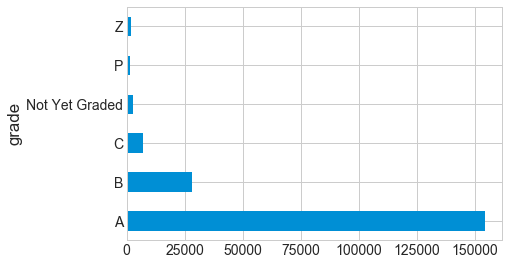

In [317]:
gradeGroup = gradeTestDF.groupby('grade').grade.count()
gradeGroup.plot(kind='barh')

In [318]:
yelpDF.columns.tolist()

['business_id', 'business_name', 'is_closed', 'rating', 'review_count', '$', '$$', '$$$']

In [319]:
gradeTestDF[['zipcode','Critical','Not Applicable','Not Critical','grade']].corr()

,Critical,Not Applicable,Not Critical
Critical,1.000000,-0.080630,-0.988238
Not Applicable,-0.080630,1.000000,-0.072746
Not Critical,-0.988238,-0.072746,1.000000


In [320]:
roc_curve(y5_test,pred5,pos_label='A')

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [321]:
rf5.score

<bound method ClassifierMixin.score of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [322]:
print(pred5)

['A' 'A' 'A' ..., 'A' 'A' 'A']


In [323]:
len(gradeTestDF[(gradeTestDF['grade']=='A')])/len(gradeTestDF)

0.7890672575519541

In [330]:
def change_grade(row):
    if row['grade'] == 'A':
        return 1
    else:
        return 0

    

In [331]:
gradeTestDF['grade_rest'] = gradeTestDF.apply(lambda row: change_grade(row),axis=1)

In [ ]:
#gradeTestDF.ix[gradeTestDF.grade=='A', 'grade'] = 1

In [ ]:
gradeTestDF.head()

In [332]:
y6 = gradeTestDF[['grade_rest']]
X6 = gradeTestDF[['zipcode','Critical','Not Applicable','Not Critical']]

In [335]:
def pred_model(model,X,y):
    m = model
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=1234)
    m.fit(X_train,y_train)
    pred = m.predict(X_test)
    return accuracy_score(y_test,pred)

In [337]:
def prob_model(model,X,y):
    m = model
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=1234)
    m.fit(X_train,y_train)
    prob = m.predict_proba(X_test)
    return roc_auc_score(y_test,pred)

In [336]:
print(pred_model(RandomForestClassifier(),X6,y6))

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.787714929039


In [338]:
print(prob_model(RandomForestClassifier(),X6,y6))

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


ValueError: Found input variables with inconsistent numbers of samples: [58624, 4538]